In [1]:
from prediction import post_process,whole_img_pred
from tqdm import tqdm_notebook as tqdm 

import torch

from Models.ModelsTorch import AttnUNet
import torch.nn.functional as F
import os 
import pandas  as pd

import shutil
import matplotlib.pyplot as plt
import random


In [2]:
from __future__ import print_function, division
import os
from PIL import Image
import math
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torchvision.models as models
from skimage.color import rgb2gray


from sklearn.utils import shuffle
import pandas as pd
from skimage.io import imread, imsave
from skimage.transform import resize


import datetime
from tqdm import tqdm_notebook as tqdm


2180


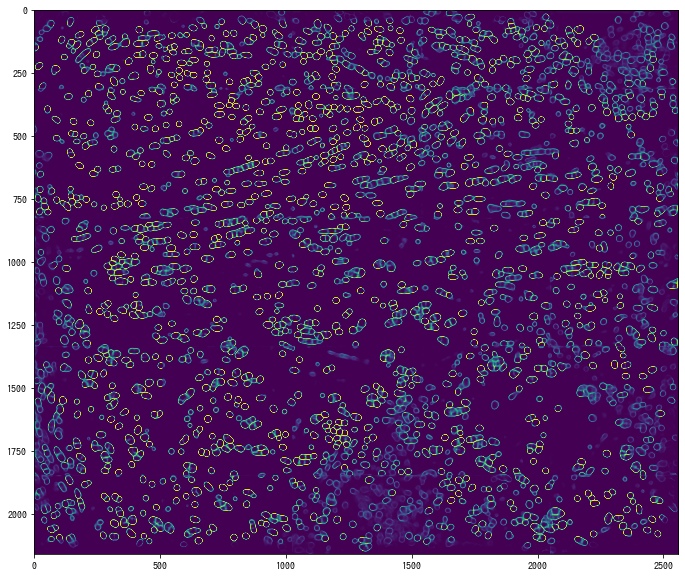

In [3]:
from skimage.measure import label, regionprops
from skimage import morphology

def coord2array(coord):
    x=[]
    y=[]
    for i in coord:
        x.append(i[0])
        y.append(i[1])
    return (x,y)
def object_level_f1(y_pred,n_array_gt):
    smooth = 10e-16
    label=1
    # single image so just roll it out into a 1D array
    
    m1 =np.reshape(y_pred,(-1))/255
    m2 =np.reshape(y_true,(-1))/255
    
    
    intersection = (m1 * m2)

    score = 2. * (np.sum(intersection) + smooth) / (np.sum(m1) +(np.sum(m2) + smooth))
        
    return score
n_array_gt=imread('Dapi_patient_data/S-190410-00044/NucSeg/NucMap_S-190410-00044_R000.tif')
y_pred=imread('Dapi_patient_data/S-190410-00044/processed/R000.tif')
bound_img=imread('Dapi_patient_data/S-190410-00044/predictions/bound_R000.png')
plt.figure(figsize=(20,10))
plt.imshow(bound_img)
x=np.zeros_like(y_pred)
thresh_bound=0.2*255
bound_img=bound_img>thresh_bound
def multiple_erosion(img,iter=5):
    for j in (range(iter)):
        img=morphology.binary_erosion(img, selem=morphology.selem.disk(1))
    return img

def multiple_dialte(img,iter=5):
    for j in (range(iter)):
        img=morphology.binary_dilation(img, selem=morphology.selem.disk(1))
    return img

# plt.figure(figsize=(20,10))
# plt.imshow(bound_img)

bound_img=multiple_dialte(bound_img,iter=3)
bound_img=multiple_erosion(bound_img,iter=3)
# plt.figure(figsize=(20,10))
# plt.imshow(bound_img)



labeled_img=label(y_pred)
regions=regionprops(labeled_img)

final_image=np.zeros_like(y_pred,dtype=np.uint16)
loop=tqdm(regions)
for i,region in enumerate(loop):
    coordinates=coord2array(list(region.coords))
    x_temp=np.zeros_like(y_pred)
    x_temp[coordinates]=1
    boundary_score=0
    iteration=0
    while boundary_score<150 and iteration<2:
        iteration+=1
        x_temp=morphology.binary_dilation(x_temp, selem=morphology.selem.disk(2)).astype(np.float)
        boundary_score=len(np.where(x_temp*bound_img==1)[0])

    final_image[np.where(x_temp==1)]=i
    
print(np.amax(final_image))
        
        

In [9]:
mask=imread('Dapi_patient_data/S-190410-00044/OverallQCMasks/OverallQCMask_S-190410-00044_R000.tif')
final_image_masked=final_image&mask

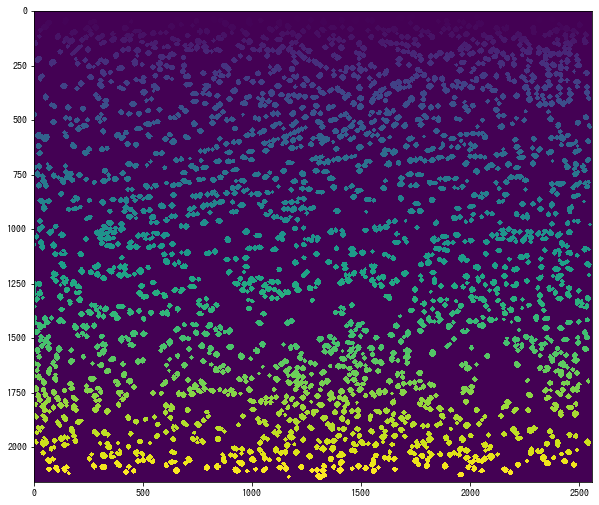

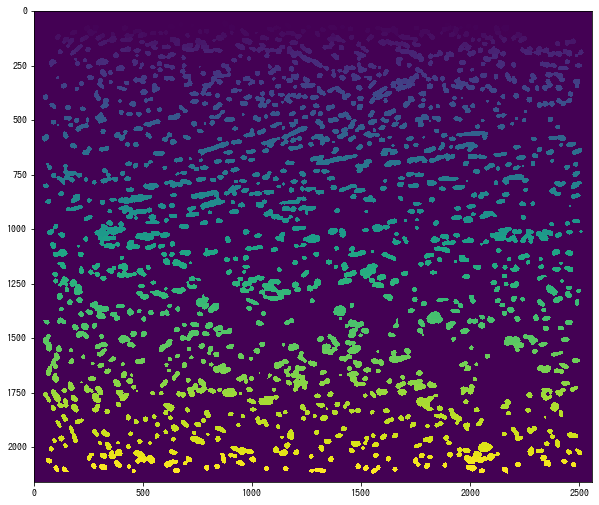

In [14]:
imsave('final.tif',final_image)
plt.figure(figsize=(10,10))
plt.imshow(final_image)
plt.figure(figsize=(10,10))
plt.imshow(n_array_gt)

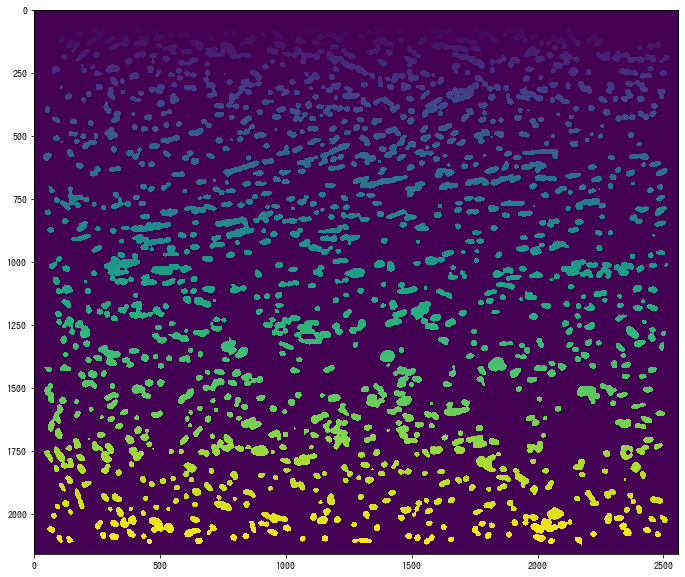

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(n_array_gt)


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(n_array_gt)


In [ ]:
x_temp=multiple_dialte(x,4)
plt.figure(figsize=(20,10))
plt.imshow(x_temp)

print(len(np.where(x_temp*bound_img==1)[0]))
plt.figure(figsize=(20,10))
plt.imshow(x_temp*bound_img)

In [ ]:
df_whole=pd.read_excel('Summary_v3_15102019.xlsx',sheet_name='whole_tissue')
df_whole.columns=[x.replace(" ","_") for x in df_whole.columns]

# Train List

S-190413-00092<br>
S-190410-00044<br>
S-190413-00078<br>
S-190413-00075


# S-190413-00241

In [ ]:
patient_list=[x for x in os.listdir('Dapi_patient_data/') if 'S-' in x and '.zip' not in x]
print("Available slides :-\n ",*patient_list,sep='\n')
patient_name=input("ENTER PATIENT SLIDE ID : ")
assert patient_name in patient_list,"Please enter valid ID  out of the list {}".format(patient_list)
IMAGE_PATH='/datalab/training-assets/R_medical/atheeth/DAPI/Dapi_patient_data/{}'.format(patient_name)
roi_list=os.listdir(IMAGE_PATH+'/ROI')
no_roi=input("Enter number of rois out of {}: ".format(len(roi_list)))
assert int(no_roi)<=len(roi_list),"Please enter valid number, lesser than or equal to {}".format(len(roi_list))
img_list=random.sample(roi_list, int(no_roi))

    
print("Selected RoIs :- \n",*img_list,sep='\n')
pred_dir_name=os.path.join(IMAGE_PATH,'predictions')
processed_dir=os.path.join(IMAGE_PATH,'processed')
# if os.path.exists(pred_dir_name):
#     shutil.rmtree(pred_dir_name)
# if os.path.exists(processed_dir):
#     shutil.rmtree(processed_dir)


In [ ]:
model=AttnUNet(img_ch=1,output_ch=2)

model.load_state_dict(torch.load('model_2019_11_13/model_optim.pth'))




In [ ]:
df_summary = pd.DataFrame(columns=['patient_name', 'ROI', 'Count','GT_count','error'])
# patient=patient_name
#patient_list=[x for x in os.listdir('Dapi_patient_data/') if 'S-' in x and '.zip' not in x]
patient_list=['S-190413-00092','S-190410-00044','S-190413-00078','S-190413-00075','S-190413-00072','S-190413-00081'\
              ,'S-190413-00072']
for patient in patient_list:
    IMAGE_PATH='/datalab/training-assets/R_medical/atheeth/DAPI/Dapi_patient_data/{}'.format(patient)
    pred_dir_name=os.path.join(IMAGE_PATH,'predictions')
    processed_dir=os.path.join(IMAGE_PATH,'processed')
    img_list=os.listdir(IMAGE_PATH+'/ROI')
#     whole_img_pred(IMAGE_PATH,img_list,pred_dir_name,model,print_prompt=True)
    df_summary=post_process(pred_dir_name,patient,img_list,df_summary,df_whole,processed_dir,threshold=0.2,print_prompt=True)
        

In [ ]:
df_summary.to_csv('generated_summary.csv',index=False)

In [ ]:
# import skimage
# from skimage.io import imread,imsave
# from skimage import morphology
# from skimage.filters import threshold_otsu
# from skimage import img_as_uint
# from tqdm import tqdm_notebook as tqdm
# import os 
# import numpy as np
# import math
# from skimage import img_as_ubyte
# from skimage.measure import moments,regionprops

# from Generators.DatasetTorch import Color

# import torch
# import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# import pandas as pd
# import random
# import matplotlib.pyplot as plt
# import cv2
# import imutils

# def multiple_erosion(img,iter=5):
#     for j in (range(5)):
#         img=morphology.binary_erosion(img, selem=morphology.selem.disk(1))
#     return img

# def multiple_dialte(img,iter=5):
#     for j in (range(5)):
#         img=morphology.binary_dilation(img, selem=morphology.selem.disk(1))
#     return img



In [ ]:
# import cv2
# PRED_PATH='Dapi_patient_data/S-190413-00241/predictions/'
# img_name='R002.tif'


# bound_img_path=os.path.join(PRED_PATH,'bound_'+img_name.split('.')[0]+'.png')
# bound_img=imread(bound_img_path)

# thresh_bound=threshold_otsu(bound_img)
# bound_img=bound_img>thresh_bound

# nuc_img_path=os.path.join(PRED_PATH,'nuclei_'+img_name.split('.')[0]+'.png')
# nuc_img=imread(nuc_img_path)

# thresh_nuclei=threshold_otsu(nuc_img)
# nuc_img=nuc_img>thresh_nuclei


# bound_img=multiple_dialte(bound_img)
# bound_img=multiple_erosion(bound_img)

# nuc_img=multiple_erosion(nuc_img)
# nuc_img=multiple_dialte(nuc_img)

# comb_img=nuc_img^bound_img
# bound_coor=np.where(bound_img==1)
# comb_img[bound_coor]=0
# comb_img=multiple_erosion(comb_img,3)
# comb_img=multiple_dialte(comb_img,3)

# gt=int(df_whole[(df_whole['ROI']==img_name.split('.')[0]) & (df_whole['Slide']==patient_name)]["ALLCELLS"])

# # imsave(processed_dir+'/'+img_name,img_as_uint(comb_img))




# labels=skimage.measure.label(comb_img)
# props= regionprops(labels)


In [ ]:

# img2=np.zeros(comb_img.shape)
# for region in props:
#     # calculate moments for each contour
#     cX,cY=region.centroid
#     cX,cY=int(cX),int(cY)
#     img2[cX-3:cX+3,cY-3:cY+3]=1
    
    
    
   

In [ ]:
# np.amax(labels)

In [ ]:
# plt.imshow(img2)

In [ ]:
# labels2=skimage.measure.label(img2)
# print(np.amax(labels2))